In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Configuration
RANDOM_STATE = 42
LATENT_DIM = 8  
EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 5e-4

torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paths (update these)
IMBALANCED_DATA_PATH = "../data/01_raw/original_imbalanced.csv"
SMOTE_DATA_PATH = "../data/02_processed/smote_augmented_train.csv"
MODEL_DRIVEN_DATA_PATH = "../data/02_processed/model_driven_synthetic.csv"


Using device: cuda


In [3]:
df_imbalanced = pd.read_csv(IMBALANCED_DATA_PATH)
df_smote = pd.read_csv(SMOTE_DATA_PATH)
df_model_driven = pd.read_csv(MODEL_DRIVEN_DATA_PATH)

print("Imbalanced Data shape:", df_imbalanced.shape)
print("SMOTE Data shape:", df_smote.shape)
print("Model-Driven Data shape:", df_model_driven.shape)


Imbalanced Data shape: (69554, 41)
SMOTE Data shape: (81906, 107)
Model-Driven Data shape: (294727, 41)


In [4]:
X = df_imbalanced.drop('target', axis=1)
y = df_imbalanced['target']

numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

X_train, _, y_train, _ = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train)
print("Processed training data shape:", X_train_processed.shape)


Processed training data shape: (48687, 106)


# Prepare Fata Groups

In [5]:
# Original minority and majority
df_train_orig = pd.concat([X_train, y_train], axis=1)
df_orig_minority = df_train_orig[df_train_orig['target'] == 1].drop('target', axis=1)
df_orig_majority = df_train_orig[df_train_orig['target'] == 0].drop('target', axis=1)

# SMOTE synthetic
smote_generator = SMOTE(random_state=RANDOM_STATE)
X_train_smote, _ = smote_generator.fit_resample(X_train_processed, y_train)
X_smote_synthetic = X_train_smote[len(X_train):]  

# Model-driven synthetic
df_model_driven_synthetic = df_model_driven[df_model_driven['target'] == 1].drop('target', axis=1)

# Transform all groups
X_orig_minority_proc = preprocessor.transform(df_orig_minority)
X_orig_majority_proc = preprocessor.transform(df_orig_majority)
X_model_driven_proc = preprocessor.transform(df_model_driven_synthetic)

print("Shapes:")
print("Original Minority:", X_orig_minority_proc.shape)
print("Original Majority:", X_orig_majority_proc.shape)
print("SMOTE Synthetic:", X_smote_synthetic.shape)
print("Model-Driven Synthetic:", X_model_driven_proc.shape)


Shapes:
Original Minority: (3895, 106)
Original Majority: (44792, 106)
SMOTE Synthetic: (40897, 106)
Model-Driven Synthetic: (250000, 106)


# AutoEncoder

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        hidden_dim_1 = max(256, input_dim // 2)
        hidden_dim_2 = max(128, input_dim // 4)
        hidden_dim_3 = max(64, latent_dim * 8)
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.BatchNorm1d(hidden_dim_1),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.BatchNorm1d(hidden_dim_2),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim_2, hidden_dim_3),
            nn.BatchNorm1d(hidden_dim_3),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim_3, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim_3),
            nn.BatchNorm1d(hidden_dim_3),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim_3, hidden_dim_2),
            nn.BatchNorm1d(hidden_dim_2),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.BatchNorm1d(hidden_dim_1),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim_1, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded


In [7]:
def train_autoencoder(model, train_loader, epochs, device):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
    
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            reconstructed, _ = model(data)
            loss = criterion(reconstructed, data)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        scheduler.step(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}, LR: {lr:.6f}')
    
    return train_losses

Epoch [10/100], Loss: 0.223930, LR: 0.000500
Epoch [20/100], Loss: 0.219859, LR: 0.000500
Epoch [30/100], Loss: 0.217531, LR: 0.000500
Epoch [40/100], Loss: 0.215651, LR: 0.000500
Epoch [50/100], Loss: 0.213715, LR: 0.000500
Epoch [60/100], Loss: 0.212298, LR: 0.000500
Epoch [70/100], Loss: 0.211211, LR: 0.000500
Epoch [80/100], Loss: 0.210403, LR: 0.000500
Epoch [90/100], Loss: 0.209542, LR: 0.000500
Epoch [100/100], Loss: 0.208819, LR: 0.000500


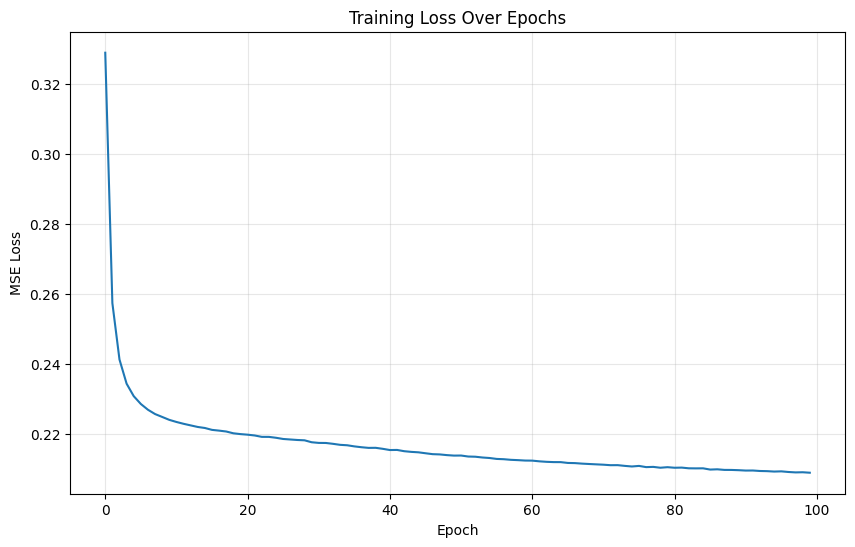

In [8]:
input_dim = X_train_processed.shape[1]
model = Autoencoder(input_dim, LATENT_DIM).to(device)

train_tensor = torch.tensor(X_train_processed.astype(np.float32))
train_dataset = TensorDataset(train_tensor, train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

train_losses = train_autoencoder(model, train_loader, EPOCHS, device)

# Plot training loss
plt.figure(figsize=(10,6))
plt.plot(train_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True, alpha=0.3)
plt.show()


In [9]:
def get_latent_representation(model, data_processed, device):
    model.eval()
    data_dense = np.array(data_processed)
    latent_representations = []
    
    batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_dense), batch_size):
            batch = data_dense[i:i+batch_size]
            tensor = torch.tensor(batch, dtype=torch.float32).to(device)
            _, encoded = model(tensor)
            latent_representations.append(encoded.cpu().numpy())
    
    return np.vstack(latent_representations)

latent_data = {
    'majority': get_latent_representation(model, X_orig_majority_proc, device),
    'minority': get_latent_representation(model, X_orig_minority_proc, device),
    'smote': get_latent_representation(model, X_smote_synthetic, device),
    'model_driven': get_latent_representation(model, X_model_driven_proc, device)
}

for k, v in latent_data.items():
    print(f"{k}: {v.shape}")


majority: (44792, 8)
minority: (3895, 8)
smote: (40897, 8)
model_driven: (250000, 8)


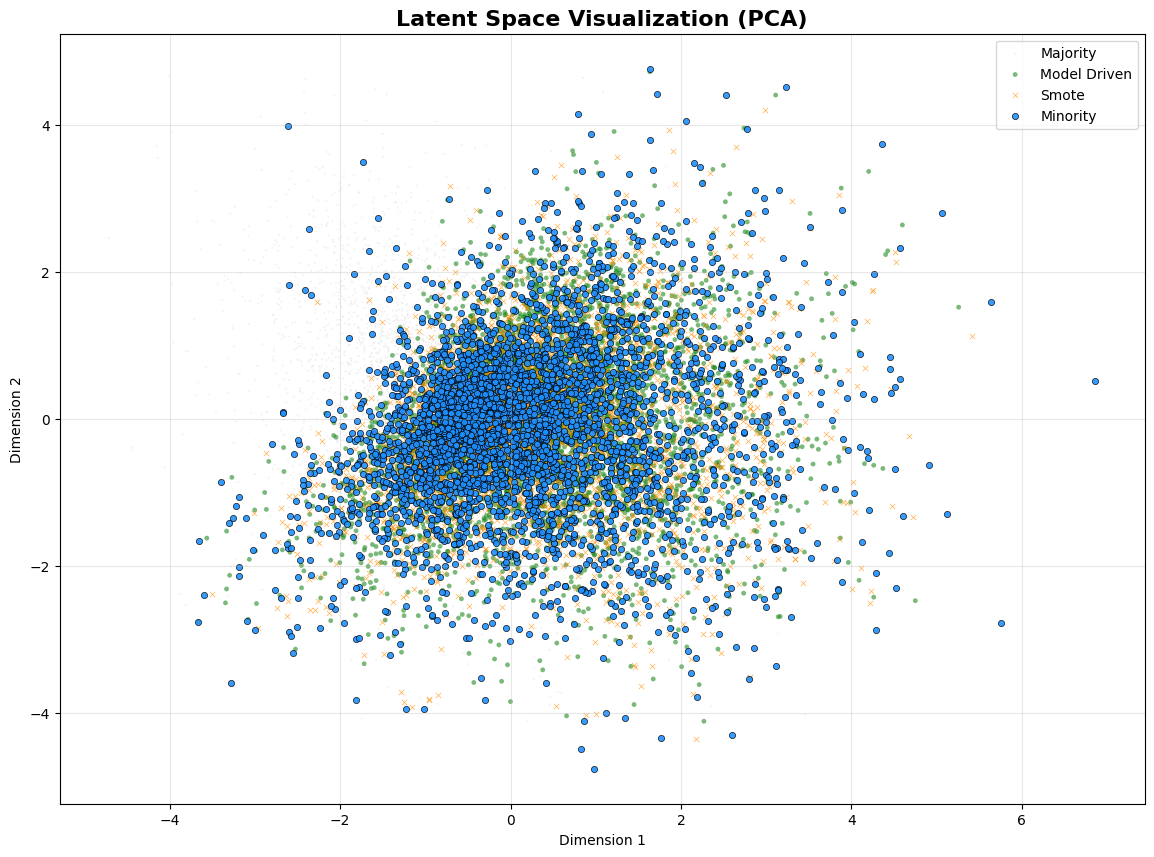

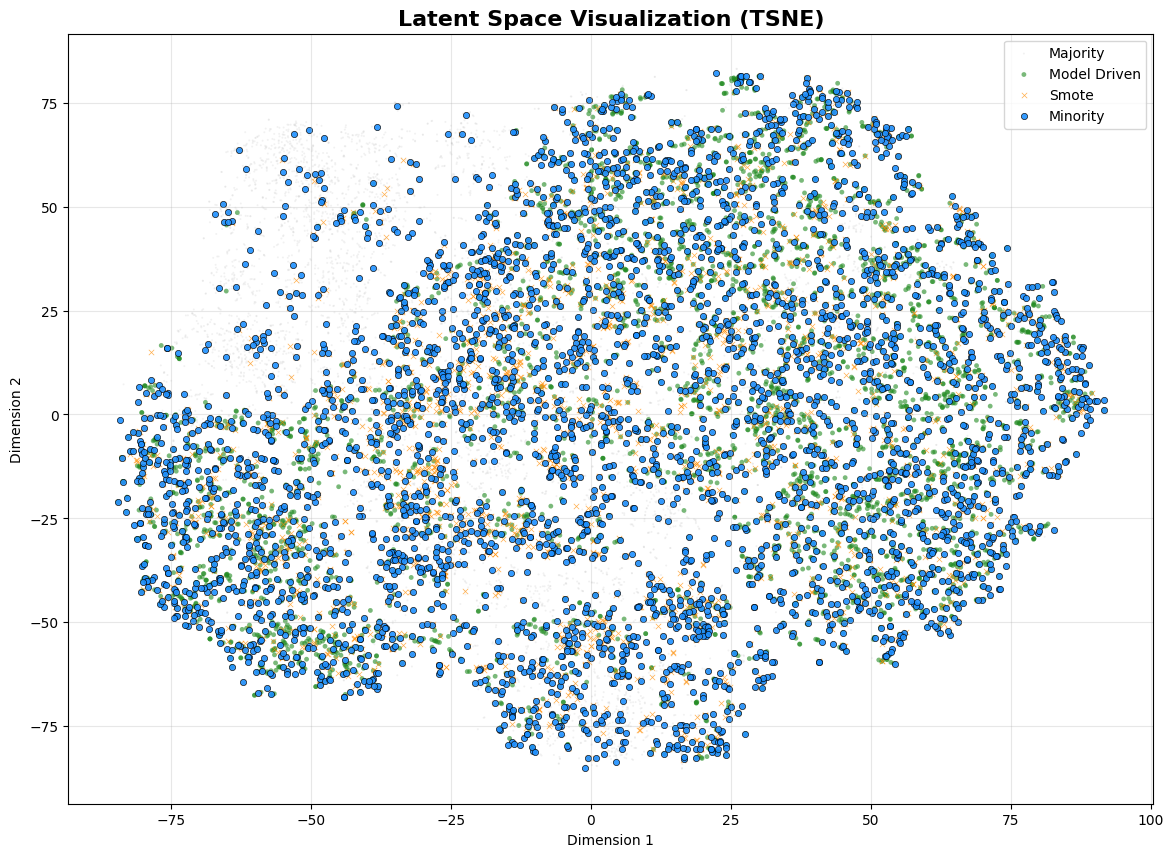

In [ ]:
def create_visualisation(latent_data_dict, method='tsne', n_samples_per_group=5000):
    sampled_data = {}
    for key, data in latent_data_dict.items():
        if len(data) > n_samples_per_group:
            indices = np.random.choice(len(data), n_samples_per_group, replace=False)
            sampled_data[key] = data[indices]
        else:
            sampled_data[key] = data
    
    if method=='tsne' and list(sampled_data.values())[0].shape[1] > 2:
        all_data = np.vstack(list(sampled_data.values()))
        tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=50, 
        max_iter=1000)
        reduced_data = tsne.fit_transform(all_data)
        start_idx=0
        for key in sampled_data.keys():
            end_idx = start_idx + len(sampled_data[key])
            sampled_data[key] = reduced_data[start_idx:end_idx]
            start_idx = end_idx
    elif method=='pca' and list(sampled_data.values())[0].shape[1] > 2:
        all_data = np.vstack(list(sampled_data.values()))
        pca = PCA(n_components=2, random_state=RANDOM_STATE)
        reduced_data = pca.fit_transform(all_data)
        start_idx=0
        for key in sampled_data.keys():
            end_idx = start_idx + len(sampled_data[key])
            sampled_data[key] = reduced_data[start_idx:end_idx]
            start_idx = end_idx
    
    colors = {'majority':'lightgray','minority':'dodgerblue','smote':'darkorange','model_driven':'forestgreen'}
    alphas = {'majority':0.3,'model_driven':0.6,'smote':0.7,'minority':0.9}
    sizes = {'majority':8,'model_driven':12,'smote':15,'minority':20}
    markers = {'majority':'.','model_driven':'o','smote':'x','minority':'o'}
    plot_order = ['majority','model_driven','smote','minority']

    plt.figure(figsize=(14,10))
    for key in plot_order:
        if key in sampled_data:
            data = sampled_data[key]
            ax = plt.gca()
            ax.scatter(data[:,0], data[:,1], c=colors[key], alpha=alphas[key],
                       s=sizes[key], marker=markers[key],
                       label=key.replace('_',' ').title(),
                       edgecolors='black' if key=='minority' else 'none', linewidths=0.5)
    plt.title(f'Latent Space Visualisation ({method.upper()})', fontsize=16, fontweight='bold')
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualizations
create_visualisation(latent_data, method='pca')
create_visualisation(latent_data, method='tsne')

In [13]:
from scipy.spatial.distance import cdist

def calculate_quality_metrics(latent_minority, latent_smote, latent_model_driven):
    metrics = {}
    sample_size = min(1000, len(latent_minority))
    idx_minority = np.random.choice(len(latent_minority), sample_size, replace=False)
    minority_sample = latent_minority[idx_minority]
    
    for name, synthetic_data in [('SMOTE', latent_smote), ('Model-Driven', latent_model_driven)]:
        idx_synthetic = np.random.choice(len(synthetic_data), sample_size, replace=False)
        synthetic_sample = synthetic_data[idx_synthetic]
        distances = cdist(synthetic_sample, minority_sample)
        avg_min_distance = np.mean(np.min(distances, axis=1))
        threshold = np.percentile(np.min(cdist(minority_sample, minority_sample) + np.eye(len(minority_sample))*1e6, axis=1), 50)
        distances_to_synthetic = cdist(minority_sample, synthetic_sample)
        coverage = np.mean(np.min(distances_to_synthetic, axis=1) < threshold)
        metrics[name] = {'avg_distance_to_original': avg_min_distance, 'coverage': coverage}
    return metrics

metrics = calculate_quality_metrics(latent_data['minority'], latent_data['smote'], latent_data['model_driven'])
for method, vals in metrics.items():
    print(f"{method} Metrics:")
    print(f"  Avg distance to original: {vals['avg_distance_to_original']:.4f}")
    print(f"  Coverage: {vals['coverage']:.2%}\n")


SMOTE Metrics:
  Avg distance to original: 0.7402
  Coverage: 58.60%

Model-Driven Metrics:
  Avg distance to original: 0.8775
  Coverage: 53.10%

